In [1]:
import os
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize1
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

##Code for analysis of fMRI experiment

In [2]:
%matplotlib inline

In [3]:
##function for reading out data from log file
def line_to_matrix(line):
	line = line.split('=')[1]
	line = line.split(',')
	line = map(float,line)
	line = np.array(line)
	new_out = line.reshape(-1,5)
	return new_out

In [4]:
##takes the mturk results file and makes a dictionary mapping
##the worker id to the assignment id
def get_assignment_id(assignment_file):
	rowNum=0
	worker_id_2_assignment_id = {}
	with(open(assignment_file,'rU')) as f:
		reader = csv.reader(f)
		#worker id is 15 and 14
		for row in reader:
	 		if rowNum > 0:
				worker_id_2_assignment_id[row[15]] = row[14]
			rowNum += 1
	return worker_id_2_assignment_id

In [5]:
##processed RT arrays. They are coded with a negative number for pre-target responses and -1
##missed responses. This replaces -1 with NaN, changes negative to positive, and offsets positive
##RTs by the delay to the target
def clean_RT(data,delay,thresh):
    count = 0
    if np.ndim(data) > 0: #array
        data[data==-1] = np.nan
        data[data==-2] = np.nan
        data[data>0] = data[data>0] + delay
        data[data<0] = data[data<0] *-1
    else: #float
        if data == -1. or data == -2.:
            data = np.nan
        elif data>0:
            data = data + delay
        elif data < 0:
            data = data *-1
            count += 1

    data = data - thresh #normalize by that subject's RT in training
    return data, count

In [6]:
##variables and paths
data_dir = os.path.abspath('../')
delay_dur = 600 ##delay before target appears

In [7]:
def process_log_files(log_files):
    full_data = {}
    for n,f in enumerate(log_files):
        
        #read file
        subj_file = open(os.path.join(data_dir,f),'r')
        subj_file = subj_file.readlines()
        subj_file = np.array(subj_file)
        
        ##need to ignore log files with no _1, _2, etc, because I didnt code
        ##rt practice differently for the at home and the in scanner practice
        flag = False
        for n,line in enumerate(subj_file):
            subject_line = line.split(' ')[1].split('=')[0].split('%20') #0th index is subid, 1st is that lines id
            if len(subject_line) == 2 and len(subject_line[0].split('_'))==2 \
                and subject_line[0].split('_')[1] == 'practice':
                    flag = True
        if flag:
            continue
        
        ##process file into dictionary of dictionaries
        subj_dict = {}
        for n,line in enumerate(subj_file):
            subject_line = line.split(' ')[1].split('=')[0].split('%20') #0th index is subid, 1st is that lines id
            if len(subject_line) == 2:
                try: 
                    full_data[subject_line[0]][subject_line[1]] = line.split(' ')[1].split('=')[1].strip('\n')
                except:
                    full_data[subject_line[0]] = {} ##make dictionary
                    full_data[subject_line[0]][subject_line[1]] = line.split(' ')[1].split('=')[1].strip('\n')
        #clean up false alarm, bonus, and description data
#         for key in full_data:
#             full_data[key]['fa_ser'] = full_data[key]['fa_ser'].split(',')[:-1]
#             full_data[key]['fa_sim'] = full_data[key]['fa_sim'].split(',')[:-1]
#             full_data[key]['instruct_ser'] = full_data[key]['instruct_ser'].replace('%20', ' ')
#             full_data[key]['instruct_sim'] = full_data[key]['instruct_sim'].replace('%20', ' ')
#             full_data[key]['bonus_ser'] = float(full_data[key]['bonus_ser'])
#             full_data[key]['bonus_sim'] = float(full_data[key]['bonus_sim'])

    return full_data

In [8]:
#preprocesses data. Takes subj_dict, string indicating which key to analyze, and dimensions to reshaping
def preprocess_data(subj_dict,key,num_entries):
    x = map(float,subj_dict[key].split(','))
    x = np.array(x)
    x = x.reshape((x.size/num_entries, num_entries))
    return x


In [9]:
##analyze reaction time data for rt thresholding task
def process_rt(full_data,subj_list, print_file_flag):
    accuracy = np.array([])
    rt_thresh = {}
    for f in full_data:
        if f in subj_list:
            if print_file_flag:
                print f
            rt = preprocess_data(full_data[f], 'rt', 3)
            rt = np.array([y for y in rt if y[0]!=-2. and y[1] < 4000 and y[0] != -1.]) #remove trials without button press, bug trials, trials with missed answers
            rt_thresh[f] = rt[-1,2] #last rt threshold of training
            ##get stats
            accuracy = np.hstack([accuracy, 1 - np.array([x for x in rt if x[0]==0.]).shape[0]/float(rt.shape[0])])
            rt = np.mean(rt, axis = 0)[1]
    return accuracy, rt_thresh

In [109]:
def analyze_rt_task(rt,rt_switch, accuracy_dict,rt_thresh, ser, rew, order,trials,cond,f):
    num_f_trials = 7
    num_switch_trials = 3

    ##collect data
    fp_plus = np.where(order == trials[0])[-1] ##ser fp +
    fp_plus = [a for n,a in enumerate(fp_plus) if rew[fp_plus][n] == 1] 
    fp_plus_rt, count = clean_RT(ser[fp_plus,1],delay_dur,rt_thresh)
    accuracy_dict['fp_accuracy'] = np.hstack([accuracy_dict['fp_accuracy'],
                                             np.sum(ser[fp_plus,0] == .25)*1.0 / num_f_trials])
    accuracy.append(pd.DataFrame(dict(condition=['fp'],
                                      subj = f.split('_')[0],
                                      exp = cond,
                                     run = f.split('_')[1],
                                     acc = accuracy_dict['fp_accuracy'][-1:])))
    
    fn_plus = np.where(order == trials[1])[-1] ##ser fn +
    fn_plus = [a for n,a in enumerate(fn_plus) if rew[fn_plus][n] == 1] 
    fn_plus_rt, count = clean_RT(ser[fn_plus,1],delay_dur,rt_thresh)
    accuracy_dict['fn_accuracy'] = np.hstack([accuracy_dict['fn_accuracy'],
                                             np.sum(ser[fn_plus,0] == .25)*1.0 / num_f_trials])
    accuracy.append(pd.DataFrame(dict(condition=['fn'],
                                      subj = f.split('_')[0],
                                      exp = cond,
                                     run = f.split('_')[1],
                                     acc = accuracy_dict['fn_accuracy'][-1:])))
    
    fp_switch = np.where(order == trials[2])[-1] ##ser fp +
    fp_switch = [a for n,a in enumerate(fp_switch) if rew[fp_switch][n] == 1] 
    fp_switch_rt, count = clean_RT(ser[fp_switch,1],delay_dur,rt_thresh)
    accuracy_dict['fp_switch_accuracy'] = np.hstack([accuracy_dict['fp_switch_accuracy'],
                                             np.sum(ser[fp_switch,0] == .25)*1.0 / num_switch_trials])    
 
    accuracy.append(pd.DataFrame(dict(condition=['fp_switch'],
                                      subj = f.split('_')[0],
                                      exp = cond,
                                     run = f.split('_')[1],
                                     acc = accuracy_dict['fp_switch_accuracy'][-1:])))
    
    fn_switch = np.where(order == trials[3])[-1] ##ser fn +
    fn_switch = [a for n,a in enumerate(fn_switch) if rew[fn_switch][n] == 1] 
    fn_switch_rt, count = clean_RT(ser[fn_switch,1],delay_dur,rt_thresh)
    accuracy_dict['fn_switch_accuracy'] = np.hstack([accuracy_dict['fn_switch_accuracy'],
                                             np.sum(ser[fn_switch,0] == .25)*1.0 / num_switch_trials]) 
    
    accuracy.append(pd.DataFrame(dict(condition=['fn_switch'],
                                  subj = f.split('_')[0],
                                  exp = cond,
                                 run = f.split('_')[1],
                                 acc = accuracy_dict['fn_switch_accuracy'][-1:])))
        
    rt.append(pd.DataFrame(dict(condition=["fn"] * num_f_trials,
                                    subj = [f] * num_f_trials,
                                    presentation = np.arange(0,num_f_trials),
                                    RT = fn_plus_rt), dtype=np.float))
    rt.append(pd.DataFrame(dict(condition=["fp"] * num_f_trials,
                            subj = [f] * num_f_trials,
                            presentation = np.arange(0,num_f_trials),
                            RT = fp_plus_rt), dtype=np.float))    
    rt_switch.append(pd.DataFrame(dict(condition=["fn"] * num_switch_trials,
                                    subj = [f] * num_switch_trials,
                                    presentation = np.arange(0,num_switch_trials),
                                    RT = fn_switch_rt), dtype=np.float))
    rt_switch.append(pd.DataFrame(dict(condition=["fp"] * num_switch_trials,
                            subj = [f] * num_switch_trials,
                            presentation = np.arange(0,num_switch_trials),
                            RT = fp_switch_rt), dtype=np.float))    
    return rt,rt_switch,accuracy_dict,accuracy


In [110]:
##MAIN ANALYSIS CODE
##make subject lists
subj_list = []
subj_list_practice = []
bad_subs = [101,102,103,106,107,108,109,111,116,120,121,122,125,131,134,139,142,145]
for i in range(101,149):
    if i not in bad_subs and i!=129: #no practice for 129
        subj_list.append(str(i)+'_1')
        subj_list.append(str(i)+'_2')
        subj_list.append(str(i)+'_3')
#         subj_list_practice.append(str(i)+'_practice')
        subj_list_practice.append(str(i))
##process data for both sim and ser experiments
log_files = glob.glob(data_dir + '/data/scanning/*log')

##process log files
full_data = process_log_files(log_files)
temp_dict = {}
for f in full_data:
    temp_dict[f] = full_data[f]
full_data = temp_dict

##analyze RT
accuracy, rt_thresh = process_rt(full_data,subj_list_practice, False)
print accuracy
print rt_thresh

[ 0.6         0.66666667  0.66666667  0.66666667  0.71428571  0.66666667
  0.73333333  0.7         0.6         0.71428571  0.66666667  0.73333333
  0.71428571  0.73333333  0.9         0.6         0.71428571  0.66666667
  0.66666667  0.73333333  0.73333333  0.53333333  0.66666667  0.64285714
  0.5         0.66666667  0.57142857  0.6       ]
{'135': 240.0, '115': 300.0, '114': 270.0, '117': 240.0, '130': 270.0, '137': 330.0, '136': 270.0, '113': 240.0, '112': 270.0, '138': 270.0, '119': 330.0, '118': 330.0, '146': 270.0, '147': 360.0, '144': 480.0, '143': 330.0, '140': 270.0, '141': 420.0, '148': 390.0, '123': 270.0, '124': 300.0, '126': 390.0, '128': 240.0, '104': 270.0, '105': 390.0, '133': 390.0, '132': 330.0, '110': 390.0}


In [178]:
##analyze rt data for the serial and simultaneous task and build dataframe
num_trials = 10 #num trials per condition
rt_sim = []
rt_switch_sim = []
rt_ser = []
rt_switch_ser = []
accuracy = []
bonus = []
bonus_s = {}
fa_sim = {}
fa_ser = {}
subs = []
accuracy_dict_ser = {'fp_accuracy': [], 'fn_accuracy': [],'fp_switch_accuracy': [], 'fn_switch_accuracy':[]}
accuracy_dict_sim = {'fp_accuracy': [], 'fn_accuracy': [],'fp_switch_accuracy': [], 'fn_switch_accuracy':[]}

for f in full_data:
    if f in subj_list:
        subs.append(f)
        
        sub = f.split('_')[0]
        run = f.split('_')[1]
        ##preprocess ser
        rt_threshold = rt_thresh[sub] #+ delay_dur##bad coding, fix later
        
        ser = preprocess_data(full_data[f], 'ser', 3)
        ser = np.array([y for y in ser if y[1] < 5000]) ##remove bug trials
        cond = np.array( map(float, full_data[f]['cond_ser'].split(',') ))
        rew =  np.array( map(float, full_data[f]['rew_ser'].split(',') ))
        order = np.array( map(float, full_data[f]['trial_order_ser'].split(',')))        
        rt_ser,rt_switch_ser,accuracy_dict_ser,accuracy = analyze_rt_task(rt_ser, rt_switch_ser, accuracy_dict_ser, rt_threshold, 
                                                                 ser, rew, order,[2,6,3,5],'ser',f)
        ##preprocesss sim
        ser = preprocess_data(full_data[f], 'sim', 3)
        ser = np.array([y for y in ser if y[1] < 5000]) ##remove bug trials
        cond = np.array( map(float, full_data[f]['cond_sim'].split(',') ))
        rew =  np.array( map(float, full_data[f]['rew_sim'].split(',') ))
        order = np.array( map(float, full_data[f]['trial_order_sim'].split(',')))  
        rt_sim,rt_switch_sim,accuracy_dict_sim,accuracy = analyze_rt_task(rt_sim, rt_switch_sim, accuracy_dict_sim, rt_threshold,
                                                                 ser, rew, order,[1,4,2,3],'sim',f)
        
        #false alarms
        if sub in fa_ser.keys():
            fa_ser[sub].append(len(full_data[f]['fa_ser'].split(',')[:-1])/2.0/20)
            fa_sim[sub].append(len(full_data[f]['fa_sim'].split(',')[:-1])/2.0/20)
        else:
            fa_ser[sub] = [len(full_data[f]['fa_ser'].split(',')[:-1])/2.0/20]
            fa_sim[sub] = [len(full_data[f]['fa_sim'].split(',')[:-1])/2.0/20]
            
        ##bous
        if run == '3':
            bonus.append(max(float(full_data[f]['bonus_sim']),float(full_data[f]['bonus_ser'])))
            bonus_s[f.split('_')[0]] = (max(float(full_data[f]['bonus_sim']),float(full_data[f]['bonus_ser'])))

rt_ser = pd.concat(rt_ser)
rt_switch_ser = pd.concat(rt_switch_ser)
rt_sim = pd.concat(rt_sim)
rt_switch_sim = pd.concat(rt_switch_sim)
accuracy = pd.concat(accuracy)

rt_ser.to_csv(data_dir + 'rt_ser.csv')
rt_switch_ser.to_csv(data_dir + 'rt_switch_ser.csv')
rt_sim.to_csv(data_dir + 'rt_sim.csv')
rt_switch_sim.to_csv(data_dir + 'rt_switch_sim.csv')
# plt.hist(bonus)

In [175]:
a = accuracy.copy(deep = True)
a.loc[a['condition'] == 'fp','acc'] = 7*a[a['condition'] == 'fp']['acc']
a.loc[a['condition'] == 'fn','acc'] = 7*a[a['condition'] == 'fn']['acc']
# a.loc[a['condition'] == 'fp_switch','acc'] = 3*a[a['condition'] == 'fp_switch']['acc']
# a.loc[a['condition'] == 'fn_switch','acc'] = 3*a[a['condition'] == 'fn_switch']['acc']
# a = a.groupby(['subj']).sum()
# a = a['acc']/120.0

a.loc[a['condition'] == 'fp_switch','acc'] = np.nan
a.loc[a['condition'] == 'fn_switch','acc'] = np.nan
a = a.groupby(['subj']).sum()
a = a['acc']/(14.0*6)

         acc  bonus    dprime     fa subj
12  0.333333   3.25  0.410894  0.200  146
14  0.654762  -0.25  0.012888  0.650  144
19  0.559524   3.25  0.338880  0.425  123
         acc  bonus    dprime        fa subj
4   0.500000  11.00  1.110772  0.133333  130
10  0.500000   5.75  0.524401  0.300000  119
12  0.333333   3.25  0.410894  0.200000  146
22  0.404762  11.75  1.718924  0.025000  128
         acc  bonus    dprime        fa subj
1   0.845238   4.25  0.848328  0.566667  133
12  0.333333   3.25  0.410894  0.200000  146
14  0.654762  -0.25  0.012888  0.650000  144
19  0.559524   3.25  0.338880  0.425000  123
20  0.619048   4.00  0.803561  0.308333  124


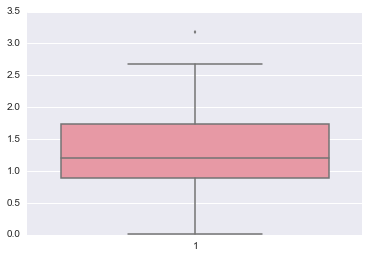

In [176]:

# accs = accuracy.groupby(['subj']).mean()
# thresh = accs.mean() - 1*accs.std()
# thresh = thresh.values[0]

# # print accs[accs['acc']<thresh]
# # print bonus_s['146']
# accuracy[accuracy['subj']=='146']

performance = {'subj':[],'acc':[],'fa':[],'bonus':[],'dprime':[]}
for s in bonus_s.keys():
    performance['subj'].append(s)
    performance['bonus'].append(bonus_s[s])
    
    correct = a[s]
    performance['acc'].append(correct)
    
    fa = np.mean(fa_ser[s] + fa_sim[s])
    performance['fa'].append(fa)
    performance['dprime'].append(scipy.stats.norm.ppf(correct) - scipy.stats.norm.ppf(fa))
performance = pd.DataFrame(performance)


print performance[performance['dprime'] < .5]

print performance[performance['acc'] < .51]
sns.boxplot(performance['dprime'].values)
# bonus = performance['acc']*120*.25 - performance['fa']*120*.25

print performance[performance['bonus']<5]

In [169]:
#made a mistake labeling these subject files. See notes
def get_sub_id(sub):        
    if sub == 'fd_125':
        sub_id = 'fd_126'
    elif sub == 'fd_126':
        sub_id = 'fd_127'
    else:
        sub_id = sub
    return sub_id

In [78]:
#write RTs to CSV for use in RT_fitting script
#custom sub list
subj_list = []
subjects = list(np.loadtxt(data_dir+ '/subjects.txt',str))
subjects.append('fd_125') #see notes
for subj in subjects:
    i = subj[-3:]    
    subj_list.append(str(i)+'_1')
    subj_list.append(str(i)+'_2')
    subj_list.append(str(i)+'_3')

#load RT data
all_rts = {'rt':[],'sub':[],'run':[],'exp':[],'order':[],'rew':[],'trial_index':[]}
timing_info = {'sub':[],'run':[],'exp':[],'onset':[],'duration':[],'condition':[],'rew':[],'rt':[],'feedback_valence':[],'PE':[]}
order_dict_ser = {6:'c_plus', 2:'b_plus', 3:'b_minus', 5:'c_minus',10:'iti',1:'A',4:'A'} #coding for trial order vector
order_dict_sim = {4:'c_plus', 1:'b_plus', 2:'b_minus', 3:'c_minus',10:'iti'}
order_dict_exp = {'ser': order_dict_ser, 'sim':order_dict_sim}

for f in full_data:
    if f in subj_list: 
        for exp in ['sim','ser']:
 
            #get RT data
            rt_data = preprocess_data(full_data[f], exp, 3)
            rt, count = clean_RT(rt_data[:,1],delay_dur,0)
            len_rt = len(rt)
            
            #deal with subject with bad RT data because of 5s
            if (f.split('_')[0] == '122') or (f == '129_1' and exp == 'sim'):
                rt = [np.nan]*len_rt

            #load relevant experiment data
            order = np.array( map(float, full_data[f]['trial_order_' + exp].split(',')))  
            rew =  np.array( map(float, full_data[f]['rew_' + exp].split(',') ))
            im_time = np.array(map(float, full_data[f]['im_time_' + exp].split(',')))
            fb_time = np.array(map(float, full_data[f]['fb_time_' + exp].split(',')))
            iti_time = np.array(full_data[f]['iti_time_' + exp].split(',')).astype('float')

            #deal with coding of order
            order = [order_dict_exp[exp][int(item)] for item in order]

            #add iti times to im_time because cond indexing includes itis
            im_time = np.concatenate((iti_time,im_time),axis=0)
            im_time = np.sort(im_time)

            #get positive or negative feedback vector
            rew_fb_data = np.array([int(entry*8-1) for entry in rt_data[:,0] if entry != -2.])
            rew_fb_data[rew_fb_data==-9] = -1 #missed responses

            #correct sub_id problem
            sub = 'fd_' + str(f.split('_')[0])
            sub_id = get_sub_id(sub)

            ##fill out RT data frame for use in RT fitting
            all_rts['rt'].extend(rt)
            all_rts['sub'].extend([sub_id]*len_rt)
            all_rts['run'].extend([f.split('_')[1]]*len_rt)
            all_rts['exp'].extend([exp]*len_rt)
            all_rts['order'].extend(order)
            all_rts['rew'].extend(rew)
            all_rts['trial_index'].extend(range(0,len_rt))

            ##fill out timing data frame for use in design files
            len_info = len(im_time) + len(fb_time)
            timing_info['onset'].extend(im_time)
            timing_info['onset'].extend(fb_time)
            timing_info['sub'].extend([sub_id]*len_info)
            timing_info['run'].extend([f.split('_')[1]]*len_info)
            timing_info['exp'].extend([exp]*len_info)
            timing_info['condition'].extend(order)
            timing_info['condition'].extend(['feedback']*len(fb_time))
            timing_info['rew'].extend(rew)
            timing_info['rew'].extend([0]*len(fb_time))
            timing_info['rt'].extend(rt)
            timing_info['rt'].extend([np.NaN]*len(fb_time))
            timing_info['feedback_valence'].extend([np.NaN]*len(im_time))
            timing_info['feedback_valence'].extend(rew_fb_data)
            timing_info['PE'].extend([np.NaN]*len_info)
            timing_info['duration'].extend([0]*len_info)
        
            
#save dataframe
all_rts = pd.DataFrame(all_rts)

#process timing info
timing_info = pd.DataFrame(timing_info)
timing_info = timing_info.sort(['exp','sub','run','onset']) #get predictors in proper order
timing_info = timing_info[timing_info['condition'] != 'iti'] #A

all_rts.to_csv(data_dir + '/all_rts.csv')      
timing_info.to_csv(data_dir + '/timing_info.csv')  

In [79]:
##analyze accuracy data
print list(accuracy.columns.values)
#print accuracy.groupby(['subj']).mean()

a = accuracy[accuracy['exp'] == 'ser']
fp = a[a['condition'] == 'fp']['acc'].values
fn = a[a['condition'] == 'fn']['acc'].values

t,p = scipy.stats.ttest_ind(fn, fp)
print t, p

['acc', 'condition', 'exp', 'run', 'subj']
-5.75216169987 4.14131113446e-08


In [114]:
runs = map(lambda x: x.split('_')[1],accuracy_data['subs'].values)
subs = map(lambda x: x.split('_')[0],accuracy_data['subs'].values)
accuracy_data['runs'] = runs
accuracy_data['subs'] = subs


KeyError: 'subs'

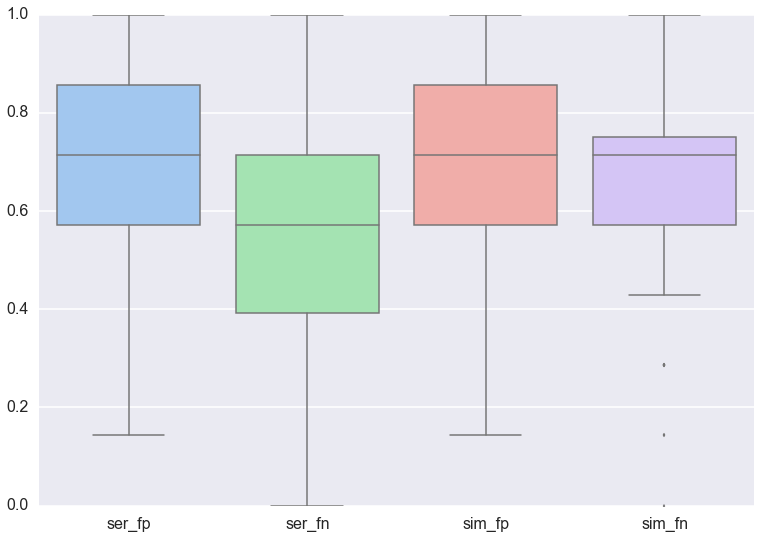

In [90]:
#plot accuracy data
num_entries = len(accuracy_dict_ser['fn_accuracy'])
s = range(0,num_entries)

accuracy_data = pd.DataFrame(dict(ser_fp=accuracy_dict_ser['fp_accuracy'],
                        ser_fn=accuracy_dict_ser['fn_accuracy'],
                        sim_fp=accuracy_dict_sim['fp_accuracy'],
                        sim_fn=accuracy_dict_sim['fn_accuracy']), 
                    columns=["ser_fp", "ser_fn", "sim_fp", "sim_fn"])

sns.boxplot(accuracy_data, color="pastel");

In [94]:
accuracy_data.mean(axis=1)

0     0.714286
1     0.821429
2     0.857143
3     0.428571
4     0.392857
5     0.392857
6     0.500000
7     0.428571
8     0.714286
9     0.714286
10    0.678571
11    0.535714
12    0.571429
13    0.250000
14    0.714286
15    0.750000
16    0.714286
17    0.785714
18    0.821429
19    0.785714
20    0.821429
21    0.607143
22    0.785714
23    0.785714
24    0.607143
25    0.785714
26    0.642857
27    0.714286
28    0.571429
29    0.250000
        ...   
54    0.750000
55    0.964286
56    0.750000
57    0.821429
58    0.642857
59    0.607143
60    0.678571
61    0.607143
62    0.785714
63    0.571429
64    0.500000
65    0.642857
66    0.464286
67    0.571429
68    0.642857
69    0.678571
70    0.535714
71    0.607143
72    0.678571
73    0.607143
74    0.607143
75    0.464286
76    0.750000
77    0.750000
78    0.500000
79    0.428571
80    0.571429
81    0.642857
82    0.535714
83    0.500000
dtype: float64

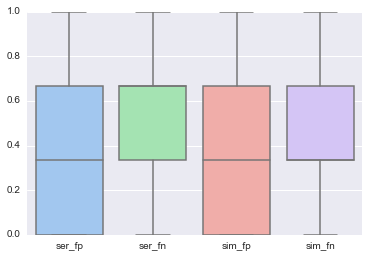

In [82]:
accuracy_data = pd.DataFrame(dict(ser_fp=accuracy_dict_ser['fp_switch_accuracy'],
                        ser_fn=accuracy_dict_ser['fn_switch_accuracy'],
                        sim_fp=accuracy_dict_sim['fp_switch_accuracy'],
                        sim_fn=accuracy_dict_sim['fn_switch_accuracy']), 
                    columns=["ser_fp", "ser_fn", "sim_fp", "sim_fn"])
sns.boxplot(accuracy_data, color="pastel");

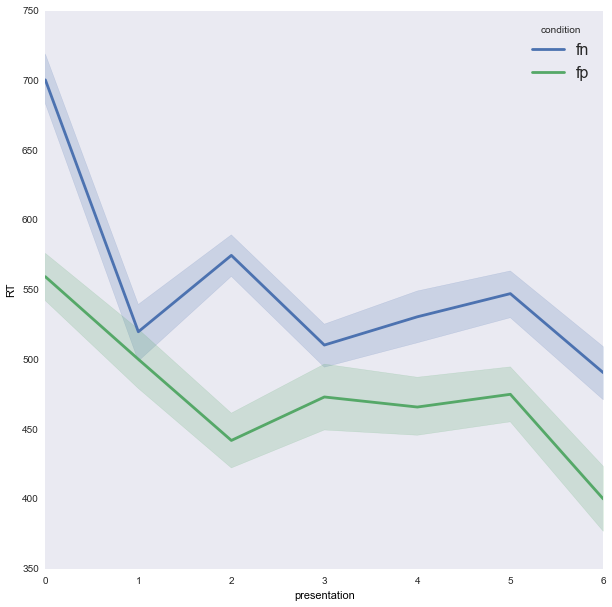

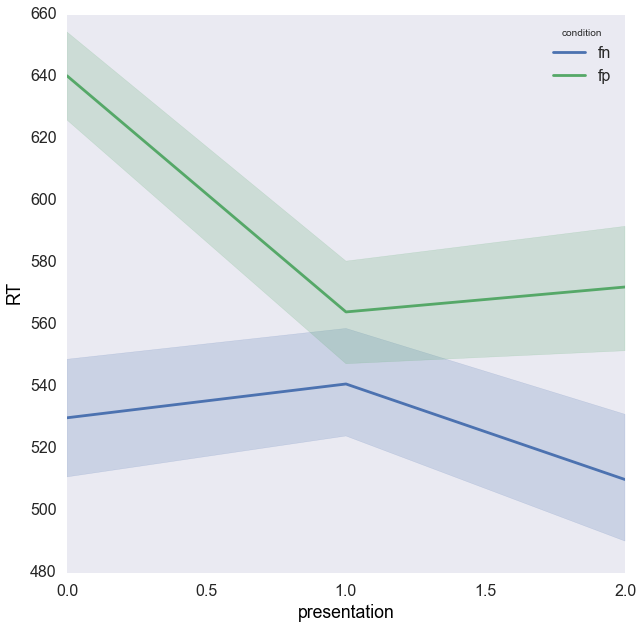

In [83]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_ser, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_switch_ser, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

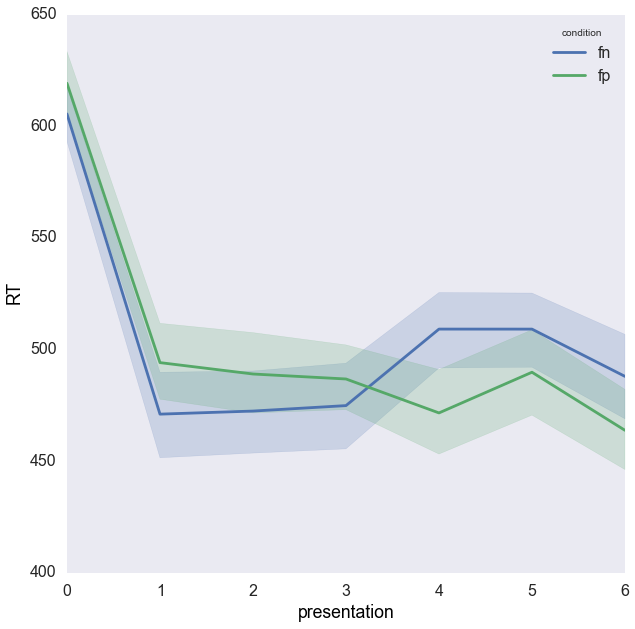

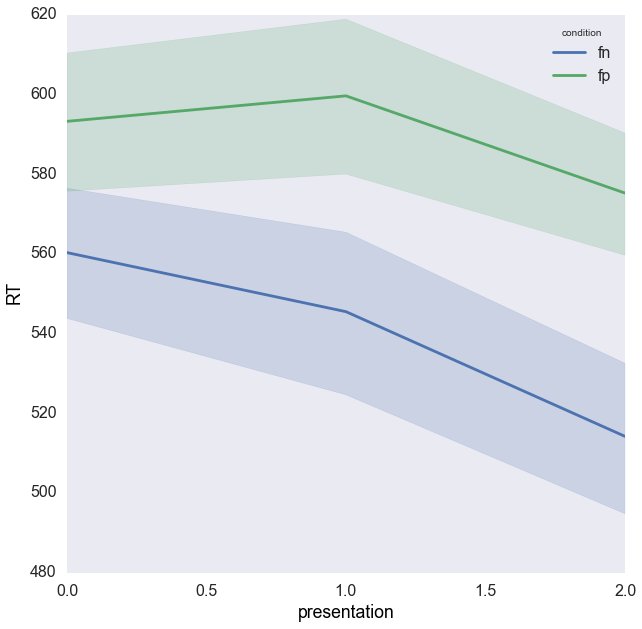

In [84]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_sim, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_switch_sim, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')


['RT', 'condition', 'presentation', 'subj']
3.81088089915 0.000194784649704


0.0116628286709 0.990708624787


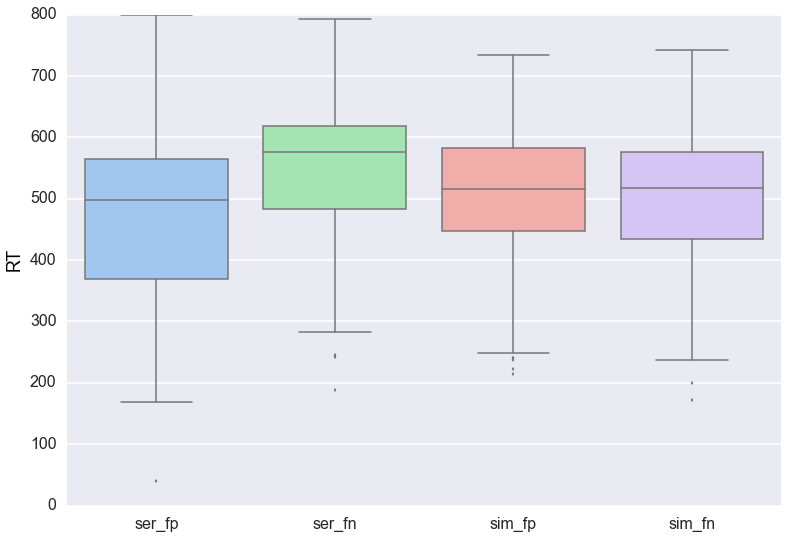

In [85]:
# print rt_ser[rt_ser['condition']=='fn']
print list(rt_ser.columns.values)

a = rt_ser[rt_ser['condition']=='fn']
b = rt_ser[rt_ser['condition']=='fp']
fn_ser= a.groupby(['subj']).mean()['RT'].values
fp_ser= b.groupby(['subj']).mean()['RT'].values

t,p = scipy.stats.ttest_ind(fn_ser, fp_ser)
print t, p

print '\n'

a = rt_sim[rt_sim['condition']=='fn']
b = rt_sim[rt_sim['condition']=='fp']
fn_sim= a.groupby(['subj']).mean()['RT'].values
fp_sim= b.groupby(['subj']).mean()['RT'].values

t,p = scipy.stats.ttest_ind(fn_sim, fp_sim)
print t, p

accuracy_data = pd.DataFrame(dict(ser_fp=fp_ser,
                        ser_fn=fn_ser,
                        sim_fp=fp_sim,
                        sim_fn=fn_sim), 
                    columns=["ser_fp", "ser_fn", "sim_fp", "sim_fn"])
sns.boxplot(accuracy_data, color="pastel");
sns.set(context='poster')
sns.despine()
plt.ylabel('RT')
plt.savefig(data_dir + 'fd_rt.tiff', dpi=600,orientation='landscape')

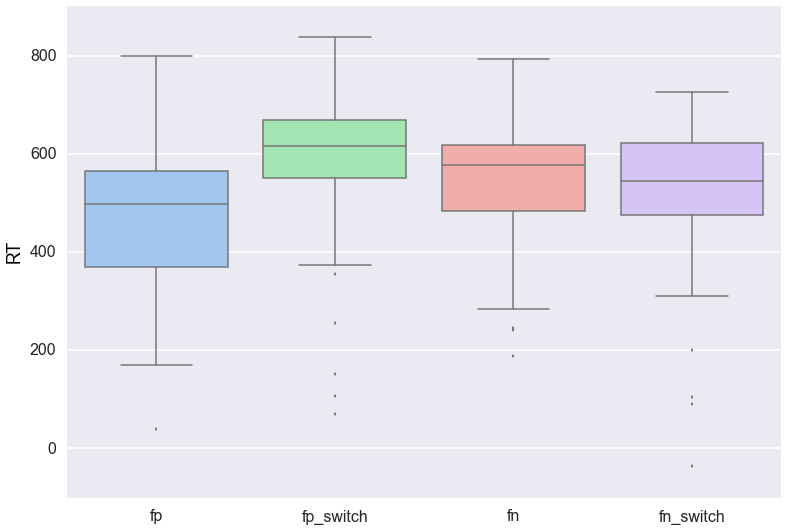

In [86]:
## compare RTs on switch trials
a = rt_switch_ser[rt_switch_ser['condition']=='fn']
b = rt_switch_ser[rt_switch_ser['condition']=='fp']
fn_switch_ser= a.groupby(['subj']).mean()['RT'].values
fp_switch_ser= b.groupby(['subj']).mean()['RT'].values

accuracy_data = pd.DataFrame(dict(fp=fp_ser,
                        fp_switch=fp_switch_ser,
                        fn=fn_ser,
                        fn_switch=fn_switch_ser), 
                    columns=["fp", "fp_switch", "fn", "fn_switch"])

sns.boxplot(accuracy_data, color="pastel");
sns.set(context='poster')
sns.despine()
plt.ylabel('RT')

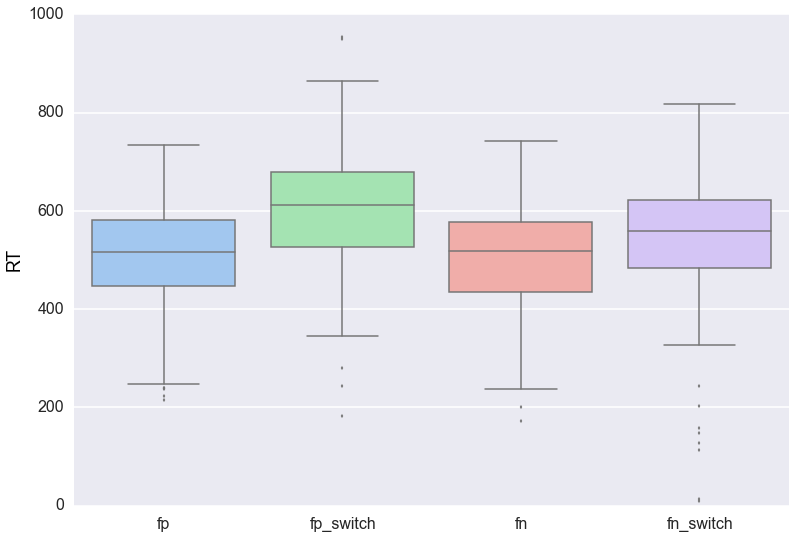

In [87]:
## compare RTs on switch trials
a = rt_switch_sim[rt_switch_sim['condition']=='fn']
b = rt_switch_sim[rt_switch_sim['condition']=='fp']
fn_switch_sim= a.groupby(['subj']).mean()['RT'].values
fp_switch_sim= b.groupby(['subj']).mean()['RT'].values

accuracy_data = pd.DataFrame(dict(fp=fp_sim,
                        fp_switch=fp_switch_sim,
                        fn=fn_sim,
                        fn_switch=fn_switch_sim), 
                    columns=["fp", "fp_switch", "fn", "fn_switch"])
sns.boxplot(accuracy_data, color="pastel");
sns.set(context='poster')
sns.despine()
plt.ylabel('RT')

-2.9773385656 0.0031240256543


-3.77313367484 0.000191257630286


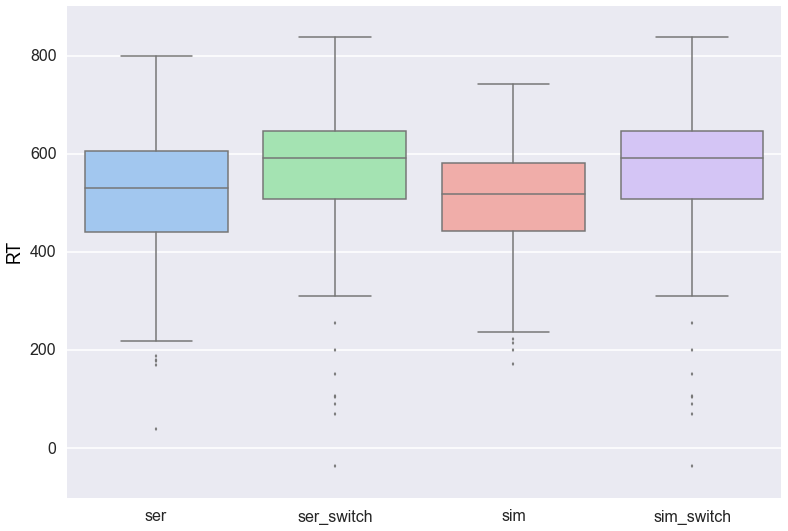

In [113]:
all_ser = np.hstack([fn_ser,fp_ser])
all_ser_switch = np.hstack([fn_switch_ser,fp_switch_ser])
all_sim = np.hstack([fn_sim,fp_sim])
all_sim_switch = np.hstack([fn_switch_ser,fp_switch_ser])

accuracy_data = pd.DataFrame(dict(ser= all_ser,
                        ser_switch= all_ser_switch,
                        sim= all_sim,
                        sim_switch= all_sim_switch),
                    columns=["ser", "ser_switch", "sim", "sim_switch"])
sns.boxplot(accuracy_data, color="pastel");
sns.set(context='poster')
sns.despine()
plt.ylabel('RT')
plt.savefig(data_dir + 'fd_rt_switch.tiff', dpi=600,orientation='landscape')

all_ser = all_ser[~np.isnan(all_ser)]
all_ser_switch = all_ser_switch[~np.isnan(all_ser_switch)]
all_sim = all_sim[~np.isnan(all_sim)]
all_sim_switch = all_sim_switch[~np.isnan(all_sim_switch)]

t,p = scipy.stats.ttest_ind(all_ser, all_ser_switch)
print t, p
t,p = scipy.stats.ttest_ind(all_sim, all_sim_switch)
print '\n'
print t,p

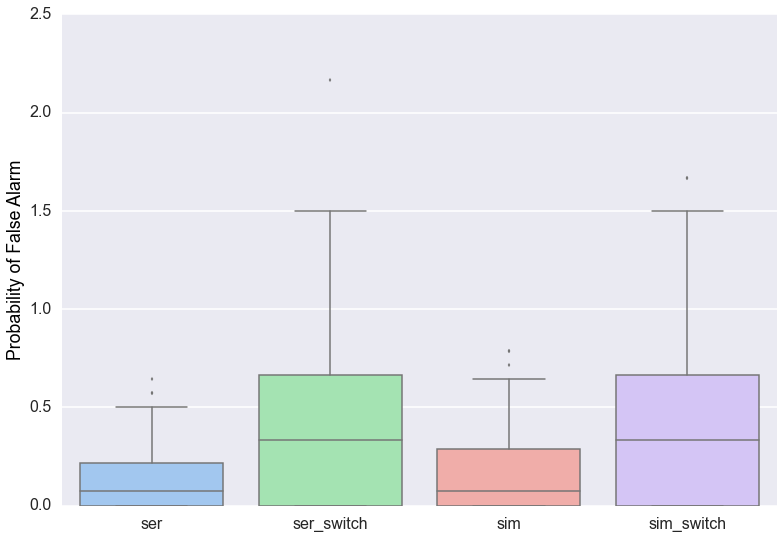

In [89]:
##analyze false alarms
ser_fa_consistent = np.zeros((1,len(subj_list)))[0]
ser_fa_switch = np.zeros((1,len(subj_list)))[0]
sim_fa_consistent = np.zeros((1,len(subj_list)))[0]
sim_fa_switch = np.zeros((1,len(subj_list)))[0]

idx=0
for f in full_data:
    if f in subj_list: 
        fa_ser = full_data[f]['fa_ser'].split(',')[:-1]
        trial_step = fa_ser[1::2]
        trial_type = fa_ser[0::2]
        trial_type = [x for n,x in enumerate(trial_type) if trial_step[n] == '3'] #only want
        #fa's while image is on
        for t in trial_type:
            if t == '3' or t == '5':
                ser_fa_consistent[idx] = ser_fa_consistent[idx] + 1
            if t == '2' or t == '6':
                ser_fa_switch[idx] = ser_fa_switch[idx] + 1
        
        fa_sim = full_data[f]['fa_sim'].split(',')[:-1]
        trial_step = fa_sim[1::2]
        trial_type = fa_sim[0::2]
        trial_type = [x for n,x in enumerate(trial_type) if trial_step[n] == '3'] #only want
        #fa's while image is on
        for t in trial_type:
            if t == '2' or t == '3':
                sim_fa_consistent[idx] = sim_fa_consistent[idx] + 1
            if t == '1' or t == '4':
                sim_fa_switch[idx] = sim_fa_switch[idx] + 1
             
        idx += 1

ser_fa_switch = [x/6.0 for x in ser_fa_switch]
sim_fa_switch = [x/6.0 for x in sim_fa_switch]
ser_fa_consistent = [x/14.0 for x in ser_fa_consistent]
sim_fa_consistent = [x/14.0 for x in sim_fa_consistent]

fa_data = pd.DataFrame(dict(ser= ser_fa_consistent,
                        ser_switch= ser_fa_switch,
                        sim= sim_fa_consistent,
                        sim_switch= sim_fa_switch),
                    columns=["ser", "ser_switch", "sim", "sim_switch"])
sns.boxplot(fa_data, color="pastel");
sns.set(context='poster')
sns.despine()
plt.ylabel('Probability of False Alarm')
plt.savefig(data_dir + 'false_alarms.tiff', dpi=600,orientation='landscape')

In [114]:
#ser
f = '914_3'
fb_iti = np.array(full_data[f]['fb_iti_ser'].split(',')).astype('float')/1000.0
iti_dur_full = np.array(full_data[f]['iti_dur_full_ser'].split(',')).astype('float')/1000.0
iti_dur = np.array(full_data[f]['iti_dur_ser'].split(',')).astype('float')/1000.0
im_time = np.array(full_data[f]['im_time_ser'].split(',')).astype('float')
fb_time = np.array(full_data[f]['fb_time_ser'].split(',')).astype('float')
iti_time = np.array(full_data[f]['iti_time_ser'].split(',')).astype('float')
tar_time = np.array(full_data[f]['tar_time_ser'].split(',')).astype('float')
cond = np.array( map(float, full_data[f]['cond_ser'].split(',') ))
rew =  np.array( map(float, full_data[f]['rew_ser'].split(',') ))
order = np.array( map(float, full_data[f]['trial_order_ser'].split(',')))

print rew
print order
itis = np.where(np.array(order) < 9)
tmp_rew = rew[itis]
rew_trials = np.where(tmp_rew == 1)
print im_time[rew_trials]
print tar_time
print tar_time - im_time[rew_trials]
print '/n'


predicted_im_time = []
predicted_iti_time = []
predicted_fb_time = []
start = im_time[0]
predicted_im_time.append(start)
im_duration = 1.5
iti_duration = .5
fb_duration = 1

for n in range(0,len(order)-1):
    if order[n] == 1 or order[n] == 4:
        next_im_time = predicted_im_time[-1] + im_duration + iti_dur_full[n]
        predicted_im_time.append(next_im_time)
    
    if order[n+1] == 10 and rew[n] == 0:
        predicted_iti_time.append(predicted_im_time[-1] + iti_dur[0] + im_duration)
        next_im_time = predicted_iti_time[-1] + iti_duration + iti_dur[0]
        iti_dur = iti_dur[1:]
        predicted_im_time.append(next_im_time)
        
    elif order[n+1] == 10 and rew[n] == 1:
        predicted_iti_time.append(predicted_fb_time[-1] + iti_dur[0] + fb_duration)
        next_im_time = predicted_iti_time[-1] + iti_duration + iti_dur[0]
        iti_dur = iti_dur[1:]
        predicted_im_time.append(next_im_time)
        
    elif rew[n + 1] == 1:
        predicted_fb_time.append(predicted_im_time[-1] + fb_iti[n+1] + im_duration)
   
        
print iti_time
print predicted_iti_time
print '\n'
print im_time
print predicted_im_time

print '\n'
print fb_time
print predicted_fb_time


[ 0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
[  1.   2.  10.   6.  10.   6.  10.   3.  10.   3.  10.   6.  10.   1.   2.
  10.   1.   2.  10.   3.  10.   3.  10.   4.   5.  10.   4.   5.  10.   1.
   2.  10.   6.  10.   3.  10.   6.  10.   4.   5.  10.   4.   5.  10.   4.
   5.  10.   3.  10.   1.   2.  10.   4.   5.  10.   4.   5.  10.   6.  10.
   3.  10.   4.   5.  10.   1.   2.  10.   1.   2.  10.   1.   2.  10.   4.
   5.  10.   6.  10.   3.  10.   1.   2.  10.   3.  10.   6.  10.   6.  10.
   3.  10.   4.   5.  10.   1.   2.  10.   6.  10.]
[  17.507427   34.515924   61.53915    75.049509  140.090904  159.097452
  172.104634

In [22]:
##sim
f = '109_2'
fb_iti= np.array(full_data[f]['fb_iti_sim'].split(',')).astype('float')/1000.0
iti_dur = np.array(full_data[f]['iti_dur_sim'].split(',')).astype('float')/1000.0
im_time = np.array(full_data[f]['im_time_sim'].split(',')).astype('float')
fb_time = np.array(full_data[f]['fb_time_sim'].split(',')).astype('float')
iti_time = np.array(full_data[f]['iti_time_sim'].split(',')).astype('float')
tar_time = np.array(full_data[f]['tar_time_sim'].split(',')).astype('float')
cond = np.array( map(float, full_data[f]['cond_sim'].split(',') ))
rew =  np.array( map(float, full_data[f]['rew_sim'].split(',') ))
order = np.array( map(float, full_data[f]['trial_order_sim'].split(',')))

# rew_idx = []
# count = 0
# for i in range(0,len(rew),2):
#     if rew[i] == 1:
#         rew_idx.append(count)
#     count += 1
# print im_time[rew_idx]
# print tar_time
# print tar_time - im_time[rew_idx]

# # print '/n'
# print order
# print rew

print rew
print order
itis = np.where(np.array(order) < 9)
tmp_rew = rew[itis]
rew_trials = np.where(tmp_rew == 1)
print im_time[rew_trials]
print tar_time
print tar_time - im_time[rew_trials]
print '/n'

predicted_im_time = []
predicted_iti_time = []
predicted_fb_time = []
start = im_time[0]
predicted_im_time.append(start)
im_duration = 1.5
iti_duration = .5
fb_duration = 1

for n in range(0,len(order)-1):
    if order[n+1] == 10 and rew[n] == 0:

        predicted_iti_time.append(predicted_im_time[-1] + iti_dur[0] + im_duration)
        next_im_time = predicted_iti_time[-1] + iti_duration + iti_dur[0]
        iti_dur = iti_dur[2:]
        predicted_im_time.append(next_im_time)
        
    elif order[n+1] == 10 and rew[n] == 1:
        
        predicted_iti_time.append(predicted_fb_time[-1] + iti_dur[0] + fb_duration)
        next_im_time = predicted_iti_time[-1] + iti_duration + iti_dur[0]
        iti_dur = iti_dur[2:]
        predicted_im_time.append(next_im_time)
        
    elif rew[n + 1] == 1:
        
        predicted_fb_time.append(predicted_im_time[-1] + fb_iti[n+1] + im_duration)
   
        
print iti_time
print predicted_iti_time
print '\n'
print im_time
print predicted_im_time
print '\n'
print fb_time
print predicted_fb_time


[ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  1.  0.]
[  1.  10.   4.  10.   1.  10.   4.  10.   4.  10.   1.  10.   3.  10.   3.
  10.   1.  10.   2.  10.   1.  10.   4.  10.   1.  10.   3.  10.   4.  10.
   4.  10.   2.  10.   1.  10.   1.  10.   3.  10.   2.  10.   3.  10.   2.
  10.   3.  10.   4.  10.   1.  10.   3.  10.   2.  10.   2.  10.   3.  10.
   2.  10.   4.  10.   2.  10.   4.  10.   3.  10.   2.  10.   2.  10.   1.
  10.   4.  10.   3.  10.]
[  25.019544   38.798056   54.216883   67.596094   81.962815   97.363081
  108.731279  122.085901  143.292634  150.639266  157.969185  179.372378
  223.749811  234.682035  246.831086  259.268499  288.639603  307.001887
  339.9112    368.935987]
[  25.62117    39.3998

In [88]:
def get_itis(all_itis,order,rew,cond_code, rew_code):
    cond = np.where([order == cond_code])[1]
    rewarded = np.where(rew[cond]== rew_code)
    indices = cond[rewarded]
    itis = all_itis[indices]
    return itis
    

In [103]:
f = '114_2'
im_time = np.array(full_data[f]['im_time_sim'].split(',')).astype('float')
iti_time = np.array(full_data[f]['iti_time_sim'].split(',')).astype('float')
fb_time = np.array(full_data[f]['fb_time_sim'].split(',')).astype('float')
cond = np.array( map(float, full_data[f]['cond_sim'].split(',') ))
rew =  np.array( map(float, full_data[f]['rew_sim'].split(',') ))
order = np.array( map(float, full_data[f]['trial_order_sim'].split(',')))
print im_time
print order
print rew

#add iti times to im_time
im_time = np.concatenate((iti_time,im_time),axis=0)
im_time = np.sort(im_time)

#SIM AB+,B-,AC-,C+
#switch: AB-,B+,AC-,C+
print get_itis(im_time,order,rew,1, 1)

[  12.006573   17.912915   25.778636   37.537239   43.399664   56.161274
   66.920804   78.674532   85.540948   98.300686  103.165081  114.930374
  130.68594   139.443511  146.304994  161.068644  170.830943  179.590808
  185.450532  202.207536  206.070841  209.934046  214.799292  221.661792
  226.525923  239.280192  250.044527  263.799191  271.561359  278.418796
  285.282013  290.147176  303.905702  311.76335   322.521266  327.385272
  331.250189  343.005358  346.867175  354.726005]
[  1.  10.   4.  10.   1.  10.   4.  10.   4.  10.   1.  10.   3.  10.   3.
  10.   1.  10.   2.  10.   1.  10.   4.  10.   1.  10.   3.  10.   4.  10.
   4.  10.   2.  10.   1.  10.   1.  10.   3.  10.   2.  10.   3.  10.   2.
  10.   3.  10.   4.  10.   1.  10.   3.  10.   2.  10.   2.  10.   3.  10.
   2.  10.   4.  10.   2.  10.   4.  10.   3.  10.   2.  10.   2.  10.   1.
  10.   4.  10.   3.  10.]
[ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  1.  0.

In [15]:
#ser
f = '914_3'
fb_iti = np.array(full_data[f]['fb_iti_ser'].split(',')).astype('float')/1000.0
iti_dur_full = np.array(full_data[f]['iti_dur_full_ser'].split(',')).astype('float')/1000.0
iti_dur = np.array(full_data[f]['iti_dur_ser'].split(',')).astype('float')/1000.0
im_time = np.array(full_data[f]['im_time_ser'].split(',')).astype('float')
fb_time = np.array(full_data[f]['fb_time_ser'].split(',')).astype('float')
iti_time = np.array(full_data[f]['iti_time_ser'].split(',')).astype('float')
tar_time = np.array(full_data[f]['tar_time_ser'].split(',')).astype('float')
cond = np.array( map(float, full_data[f]['cond_ser'].split(',') ))
rew =  np.array( map(float, full_data[f]['rew_ser'].split(',') ))
order = np.array( map(float, full_data[f]['trial_order_ser'].split(',')))
print order

#1 A, 2 B+, 3 B-, 4 A, 5 C-, 6 C+

[  1.   2.  10.   6.  10.   6.  10.   3.  10.   3.  10.   6.  10.   1.   2.
  10.   1.   2.  10.   3.  10.   3.  10.   4.   5.  10.   4.   5.  10.   1.
   2.  10.   6.  10.   3.  10.   6.  10.   4.   5.  10.   4.   5.  10.   4.
   5.  10.   3.  10.   1.   2.  10.   4.   5.  10.   4.   5.  10.   6.  10.
   3.  10.   4.   5.  10.   1.   2.  10.   1.   2.  10.   1.   2.  10.   4.
   5.  10.   6.  10.   3.  10.   1.   2.  10.   3.  10.   6.  10.   6.  10.
   3.  10.   4.   5.  10.   1.   2.  10.   6.  10.]
